# Standalone figure builder: S5, 7, S6

This notebook re-creates `figure_S5`, `figure_7`, and `figure_S6` using the same reads and processing as the paper figures.
It is arranged to behave like AGU25 when run top-to-bottom.


In [28]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import xarray as xr
import scipy.io as sio
from scipy.io import loadmat
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import get_cmap

# Repo utilities

def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / '.git').exists():
            return p
    return start

here = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
repo_root = find_repo_root(here)
sys.path.append(str(repo_root / 'common' / 'python' / 'plotting'))
sys.path.append(str(repo_root / 'common' / 'python' / 'io'))
sys.path.append(str(repo_root / 'projects' / 'matlab2python' / 'shared' / 'python'))

from geospatial_plotting import REGION_BOUNDS, load_ease_grid, build_ease_grid_mapping
from read_GEOSldas import read_tilecoord

# Figure output helper
if 'SAVE_DIR' not in globals():
    from itertools import count
    SAVE_DIR = Path('paper_figures')
    SAVE_DIR.mkdir(parents=True, exist_ok=True)
    _fig_counter = count(1)
    def save_fig(fig, name=None):
        idx = next(_fig_counter)
        base = name if name is not None else f"figure_{idx}"
        fig.savefig(SAVE_DIR / f"{base}.png", dpi=300, bbox_inches='tight', pad_inches=0.04)
        fig.savefig(SAVE_DIR / f"{base}.pdf", bbox_inches='tight', pad_inches=0.04)
        return base


In [29]:
# ------------------------------
# 1) Load TC stats
# ------------------------------
DATA_DIR = Path('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data')

p_cntl = DATA_DIR / 'CYGNSS_Experiments/Evaluation/IVs/ASCL4_SMPL3_OLv8_M36_cd_TC_stats_201808_202405.mat'
p_da   = DATA_DIR / 'CYGNSS_Experiments/Evaluation/IVs/ASCL4_SMPL3_DAv8_M36_cd_TC_stats_201808_202405.mat'

# Load .mat (squeeze to 1D vectors)

def _vec(x):
    return np.asarray(x).squeeze()

M0 = loadmat(p_cntl, squeeze_me=True, struct_as_record=False)
M1 = loadmat(p_da,   squeeze_me=True, struct_as_record=False)

# expected vars: 'lons','lats','N_sm','Nmin','R2_TC_L3','R2_TC_ASC','R2_TC_mod',
# 'sigma2_L3','sigma2_mod','sigma2_ASC','R_mod_L3','R_mod_ASC','R_ASC_L3',
# 'C_L3_mod','C_mod_ASC','C_L3_ASC'

def grab(M, name):
    if name not in M:
        raise KeyError(f"Missing '{name}' in file")
    return _vec(M[name])

# grid shape from lons/lats
lons_tc_grid = grab(M0, 'lons')
lats_tc_grid = grab(M0, 'lats')

if lons_tc_grid.ndim == 2 and lats_tc_grid.ndim == 2:
    shp = lons_tc_grid.shape
else:
    # If saved flat, set to your grid dims and reshape
    nlon, nlat = 406, 964
    shp = (nlon, nlat)
    lons_tc_grid = lons_tc_grid.reshape(shp)
    lats_tc_grid = lats_tc_grid.reshape(shp)

# Helpers to coerce arrays to 2D grid

def as_grid(M, key, shp):
    a = grab(M, key)
    if a.ndim == 2 and a.shape == shp:
        return a
    if a.size == np.prod(shp):
        return a.reshape(shp)
    # Some MATLAB saves may come as (nlat, nlon); handle simple transpose case
    if a.ndim == 2 and a.shape == (shp[1], shp[0]):
        return a.T
    raise ValueError(f"Field '{key}' has unexpected shape {a.shape}, cannot map to {shp}")


def get_fields(M, shp):
    grid_keys = [
        'N_sm',
        'R2_TC_L3', 'R2_TC_ASC', 'R2_TC_mod',
        'sigma2_L3', 'sigma2_mod', 'sigma2_ASC',
        'R_mod_L3', 'R_mod_ASC', 'R_ASC_L3',
        'C_L3_mod', 'C_mod_ASC', 'C_L3_ASC',
    ]
    out = {k: as_grid(M, k, shp) for k in grid_keys}
    out['Nmin'] = float(grab(M, 'Nmin'))
    return out

S0 = get_fields(M0, shp)  # CNTL
S1 = get_fields(M1, shp)  # CYG_DA


In [30]:
# ------------------------------
# 2) Compute metrics
# ------------------------------
# Common-valid mask
Nmin = int(np.nanmax(S0['Nmin']))
Mvalid = (
    (S0['N_sm'] >= Nmin) & (S1['N_sm'] >= Nmin) &
    np.isfinite(S0['R2_TC_mod']) & np.isfinite(S1['R2_TC_mod']) &
    np.isfinite(S0['sigma2_mod']) & np.isfinite(S1['sigma2_mod'])
)

# Clamp R2 to (0,1]

def clamp01(a):
    out = a.copy()
    out[(out <= 0) | (~np.isfinite(out))] = np.nan
    out[out > 1] = 1.0
    return out

R2m0 = clamp01(S0['R2_TC_mod'])
R2m1 = clamp01(S1['R2_TC_mod'])

# ΔR2 and %Δsigma2
# (a) change in R² (positive is better)
dR2_mod = np.where(Mvalid, R2m1 - R2m0, np.nan)

# (c) change in model error variance (sigma²_mod) and % change
sig20 = S0['sigma2_mod']
sig21 = S1['sigma2_mod']

# mask tiny baseline sigma2 before % change
p10 = np.nanpercentile(sig20, 10)
baseline_floor = max(1e-8, p10)
good_base = Mvalid & np.isfinite(sig20) & (sig20 > baseline_floor)

pct_sig2 = np.full_like(sig20, np.nan)
pct_sig2[good_base] = 100.0 * (sig21[good_base] / sig20[good_base] - 1.0)

# Flatten for mapping
pct_sig2_vec = np.asarray(pct_sig2.flatten(), dtype=float)
dR2_mod_vec = np.asarray(dR2_mod.flatten(), dtype=float)


In [31]:
# ------------------------------
# 3) Load aridity / LAI climatology
# ------------------------------
fn = DATA_DIR / 'CYGNSS_Experiments/Evaluation/IVs/aridity_indices_model_net_rad_20180801_20240630.nc4'
ds = xr.open_dataset(fn, decode_times=True)

ai = ds['AI_clim'].values
lon_ai = ds['lon'].isel(time=1).values
lat_ai = ds['lat'].isel(time=1).values
mean_lai_clim = ds['mean_lai_clim'].values

ai_flat = np.squeeze(ai)
lon_flat_ai = np.squeeze(lon_ai)
lat_flat_ai = np.squeeze(lat_ai)
mean_lai_flat = np.squeeze(mean_lai_clim)

# For AGU25-like behavior, use the aridity/LAI grid for KDTree targets
pred_lon_flat = lon_flat_ai
pred_lat_flat = lat_flat_ai


In [32]:
# ------------------------------
# 4) Load TC observation error variances for KDTree (sigma2_CYG)
# ------------------------------
p_tc_obs = DATA_DIR / 'CYGNSS_Experiments/Evaluation/IVs/ASCL4_SMPL3_CYGL3_OLv8_M36_cd_TC_stats_201808_202405.mat'
M2 = loadmat(p_tc_obs, squeeze_me=True, struct_as_record=False)

lons_tc = np.asarray(grab(M2, 'lons')).ravel()
lats_tc = np.asarray(grab(M2, 'lats')).ravel()

sigma2_CYG = np.asarray(grab(M2, 'sigma2_CYG'), dtype=float)


In [33]:
# ------------------------------
# 5) KDTree mapping (AGU25-like: targets mapped to aridity grid)
# ------------------------------
vec_pts = np.column_stack((np.ravel(lons_tc), np.ravel(lats_tc)))
flat_pts = np.column_stack((np.ravel(pred_lon_flat), np.ravel(pred_lat_flat)))

kdtree = cKDTree(vec_pts)
_, idxs = kdtree.query(flat_pts, k=1)

# Map targets to the aridity grid ordering
pct_sig2_flat_to_map = pct_sig2_vec[idxs]

# targets aligned to pred_lon_flat/pred_lat_flat order

target_dR2 = np.ravel(dR2_mod_vec)[idxs]
target_dR2_name = 'Δ R²_mod (DA - CNTL)'
# Clip extreme outliers (1-99 percentiles)
p_low, p_high = np.nanpercentile(target_dR2, [1, 99])
target_dR2 = np.where((target_dR2 < p_low) | (target_dR2 > p_high), np.nan, target_dR2)


target_pct_sig2 = np.ravel(pct_sig2_vec)[idxs]
target_pct_sig2_name = '% Δ sigma2_mod (DA vs CNTL)'
# Clip extreme outliers (1-99 percentiles)
p_low, p_high = np.nanpercentile(target_pct_sig2, [1, 99])
target_pct_sig2 = np.where((target_pct_sig2 < p_low) | (target_pct_sig2 > p_high), np.nan, target_pct_sig2)


In [34]:
# ------------------------------
# 6) Tilecoord + vegetation (tile grid)
# ------------------------------
ftc = DATA_DIR / 'CYGNSS_Experiments/DAv8_M36_cd/DAv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/rc_out/DAv8_M36_cd.ldas_tilecoord.bin'

tc = read_tilecoord(ftc)
tile_id = np.array(tc['tile_id'], dtype=int)
com_lon = tc['com_lon']
com_lat = tc['com_lat']

mosaic_path = DATA_DIR / 'mosaic_veg_typs_fracs'

PRIMARY_THRESH = 49.0
BARE_MAX = 10.0
SPARSE_MAX = 20.0
MIXED_MIN = 20.0

BARE_CODE = 0
MIXED_CODE = 7
SPARSE_CODE = 8

cols = [
    'tile_index', 'pfaf_code', 'primary_veg_type', 'secondary_veg_type',
    'primary_veg_frac', 'secondary_veg_frac', 'canopy_height', 'ASCATz0'
]

records = []
with open(mosaic_path, 'r') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        if len(parts) != 8:
            parts = parts[-8:]
        ti, pf, pty, sty = map(int, parts[:4])
        pfra, sfra, canh, z0 = map(float, parts[4:])
        records.append((ti, pf, pty, sty, pfra, sfra, canh, z0))

df = pd.DataFrame(records, columns=cols).set_index('tile_index')
sub = df.reindex(tile_id)

p_type = sub['primary_veg_type'].astype('float')
p_frac = sub['primary_veg_frac']
s_frac = sub['secondary_veg_frac']
tot_frac = p_frac + s_frac

veg_code = np.full(len(sub), np.nan)

mask_bare = tot_frac < BARE_MAX
veg_code[mask_bare] = BARE_CODE

mask_sparse = (~mask_bare) & (tot_frac <= SPARSE_MAX)
veg_code[mask_sparse] = SPARSE_CODE

mask_primary = np.isnan(veg_code) & (p_frac > PRIMARY_THRESH)
veg_code[mask_primary] = p_type[mask_primary]

mask_mixed = np.isnan(veg_code) & (tot_frac > MIXED_MIN) & (p_frac <= PRIMARY_THRESH)
veg_code[mask_mixed] = MIXED_CODE

veg_code[np.isnan(veg_code)] = SPARSE_CODE

veg_type_out = veg_code.astype(int)


reading from /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd/DAv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/rc_out/DAv8_M36_cd.ldas_tilecoord.bin
done reading file


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_66932/3248971186.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True, flierprops={'markersize': 3, 'marker': 'o'})
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_66932/3248971186.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize': 3, 'marker': 'o'})
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_66932/3248971186.py:115: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes_r2[2].boxplot(data_list, labels=labels,

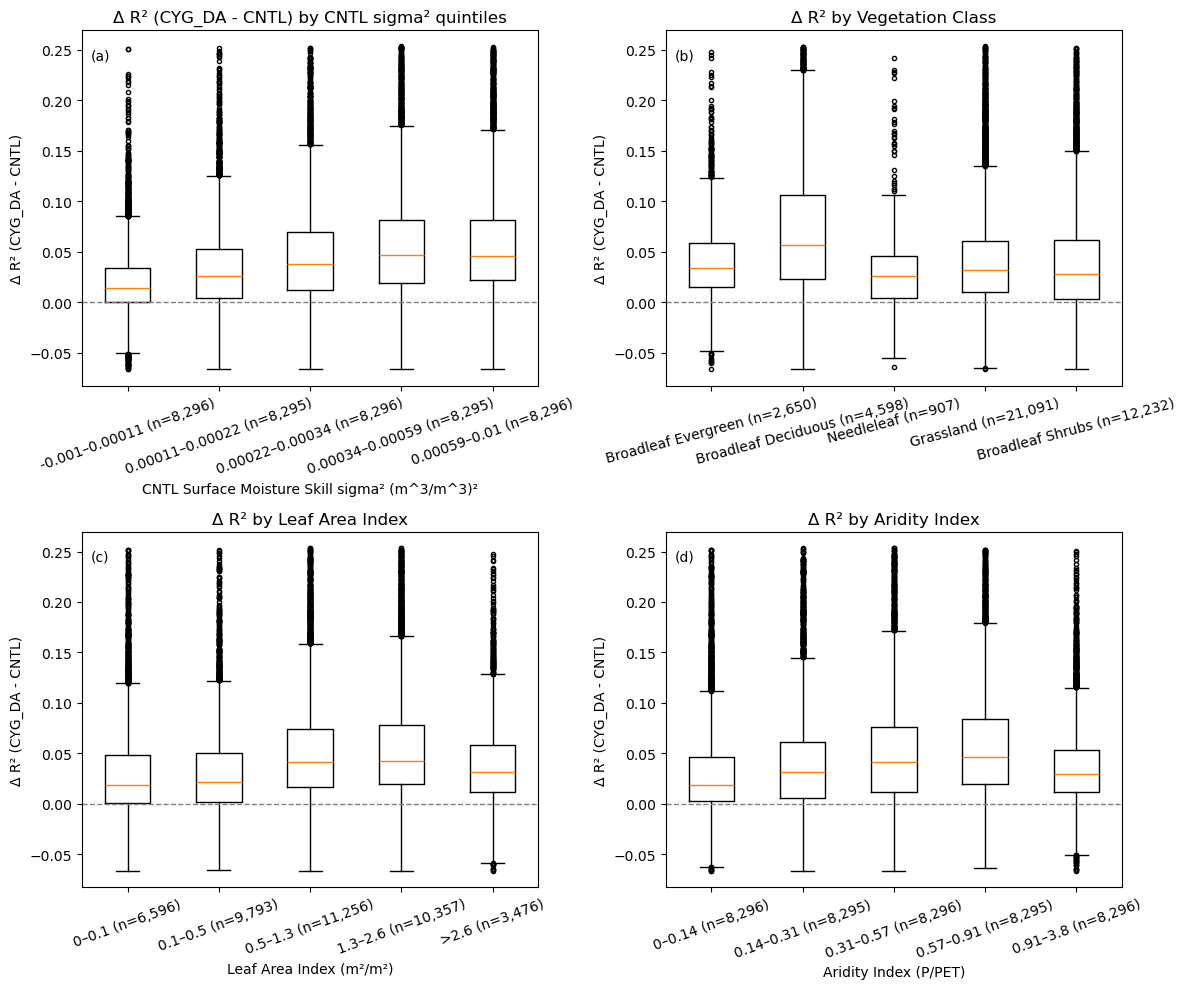

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_66932/3248971186.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True, flierprops={'markersize': 3, 'marker': 'o'})
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_66932/3248971186.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize': 3, 'marker': 'o'})
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_66932/3248971186.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes_pct[2].boxplot(data_list, labels=labels

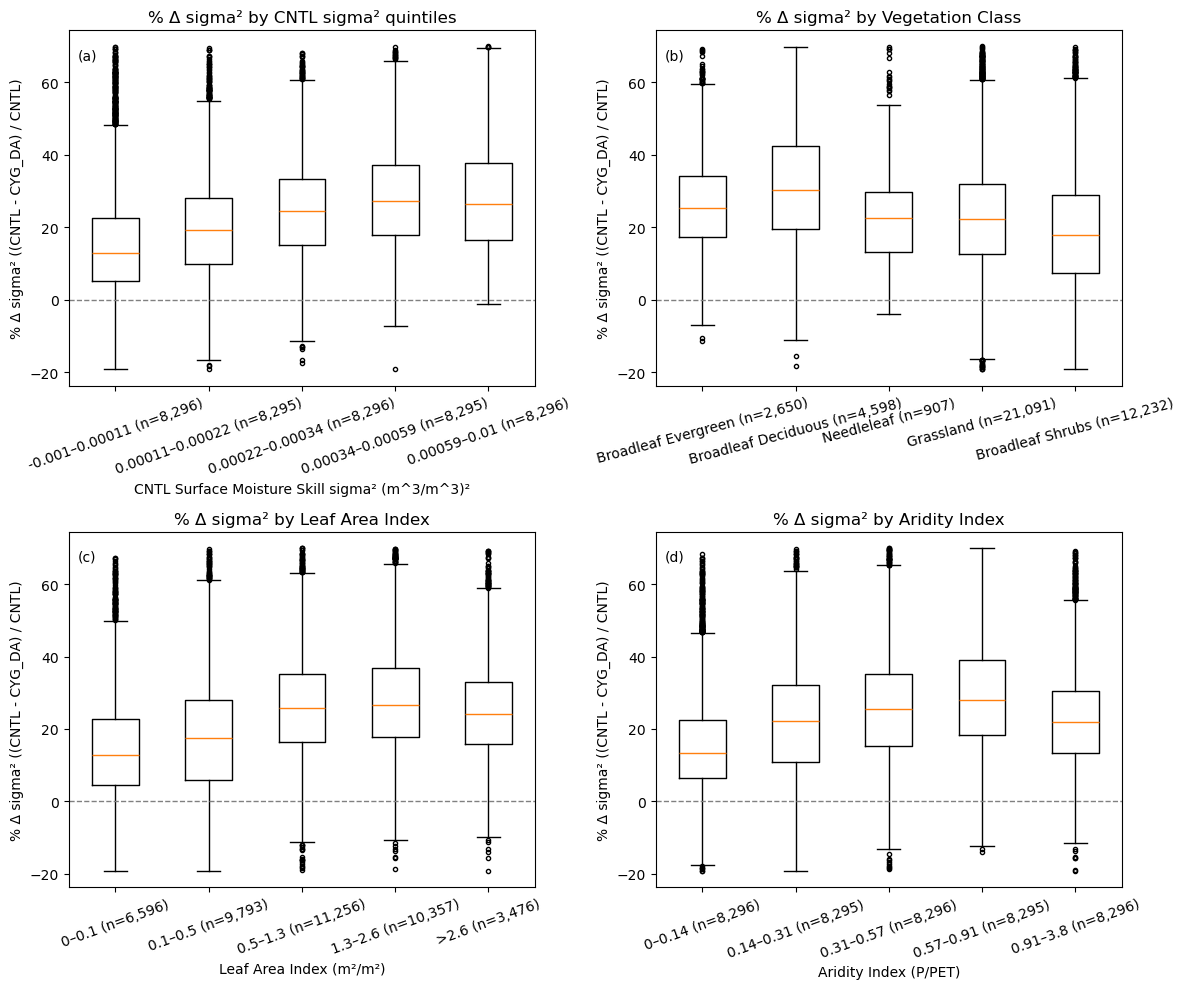

In [35]:
# ------------------------------
# 7) Figure S5 and Figure 7 (2x2 panels)
# ------------------------------
# Helpers

def box_by_bins(ax, df, col, title, ylabel):
    data, labels = [], []
    for lbl in df['bin'].cat.categories:
        vals = df.loc[df['bin'] == lbl, col].values
        data.append(vals)
        labels.append(f"{lbl.left:.2g}–{lbl.right:.2g} (n={len(vals):,})")
    ax.boxplot(data, labels=labels, showfliers=True, flierprops={'markersize': 3, 'marker': 'o'})
    ax.axhline(0, ls='--', lw=1, color='gray')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    for tick in ax.get_xticklabels():
        tick.set_rotation(20)
    ax.set_xlabel('CNTL Surface Moisture Skill sigma² (m^3/m^3)²')


def box_cat(ax, cats, data, title, ylabel, labels_map=None, order=None, xrot=15):
    data_list = []
    labels = []
    if order is None:
        order = np.unique(cats[np.isfinite(cats)])
    for k in order:
        sel = np.isfinite(cats) & (cats == k) & np.isfinite(data)
        if sel.any():
            data_list.append(data[sel])
            lab = labels_map.get(k, str(k)) if labels_map else str(k)
            labels.append(f"{lab} (n={sel.sum():,})")
    ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize': 3, 'marker': 'o'})
    ax.axhline(0, ls='--', lw=1, color='gray')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    for tick in ax.get_xticklabels():
        tick.set_rotation(xrot)

# Sigma2 quintile bins (using CNTL sigma2_mod aligned to target grid)
sig20_flat = S0['sigma2_mod'].flatten()
tr_dR2_al = target_dR2
tr_pct_al = target_pct_sig2

sig20_al = sig20_flat[idxs]
mask = np.isfinite(sig20_al) & np.isfinite(tr_dR2_al) & np.isfinite(tr_pct_al)
sig20_al = sig20_al[mask]
tr_dR2_al = tr_dR2_al[mask]
tr_pct_al = tr_pct_al[mask]

tr_pct_inv_al = -tr_pct_al  # CNTL - CYG_DA normalized by CNTL

df_sig_inv = pd.DataFrame({
    'sig20': sig20_al,
    'dR²': tr_dR2_al,
    'pct': tr_pct_inv_al,
}).replace([np.inf, -np.inf], np.nan).dropna()

try:
    df_sig_inv['bin'] = pd.qcut(df_sig_inv['sig20'], q=5, duplicates='drop')
except Exception:
    df_sig_inv['bin'] = pd.cut(df_sig_inv['sig20'], bins=5)

veg_labels = {
    0: 'Bare', 1: 'Broadleaf Evergreen', 2: 'Broadleaf Deciduous', 3: 'Needleleaf',
    4: 'Grassland', 5: 'Broadleaf Shrubs', 6: 'Dwarf Trees', 7: 'Mixed', 8: 'Sparse'
}
veg_order = [1, 2, 3, 4, 5, 6, 7, 8, 0]

veg_vec = veg_type_out.flatten()
lai_vals = np.clip(mean_lai_flat, 0, None)
ai_vals = np.clip(ai_flat, 0, None)

# base targets (AGU25-style mapping)
tr_dR2 = target_dR2
tr_pct = target_pct_sig2

# common mask to align lengths
min_len = min(len(veg_vec), len(tr_dR2), len(tr_pct), len(lai_vals), len(ai_vals))
veg_vec = veg_vec[:min_len]
tr_dR2_use = tr_dR2[:min_len]
tr_pct_use = tr_pct[:min_len]
lai_vals = lai_vals[:min_len]
ai_vals = ai_vals[:min_len]

mask_common = np.isfinite(veg_vec) & np.isfinite(tr_dR2_use) & np.isfinite(tr_pct_use) & np.isfinite(lai_vals) & np.isfinite(ai_vals)
veg_vec = veg_vec[mask_common]
tr_dR2_use = tr_dR2_use[mask_common]
tr_pct_use = tr_pct_use[mask_common]
lai_vals = lai_vals[mask_common]
ai_vals = ai_vals[mask_common]

# invert so positive = CNTL - CYG_DA
tr_pct_use = -tr_pct_use

# Figure S5: Δ R2
fig_r2, axes_r2 = plt.subplots(2, 2, figsize=(12, 10))
axes_r2 = axes_r2.flatten()

box_by_bins(axes_r2[0], df_sig_inv, 'dR²', 'Δ R² (CYG_DA - CNTL) by CNTL sigma² quintiles', 'Δ R² (CYG_DA - CNTL)')
box_cat(axes_r2[1], veg_vec, tr_dR2_use, 'Δ R² by Vegetation Class', 'Δ R² (CYG_DA - CNTL)', veg_labels, veg_order)

lai_bins = [0.0, 0.10, 0.50, 1.30, 2.60, np.inf]
lai_df = pd.DataFrame({'lai': lai_vals, 'dR²': tr_dR2_use}).replace([np.inf, -np.inf], np.nan).dropna(subset=['lai'])
lai_df['bin'] = pd.cut(lai_df['lai'], bins=lai_bins, include_lowest=True)

data_list = []
labels = []
for lbl in lai_df['bin'].cat.categories:
    vals = lai_df.loc[lai_df['bin'] == lbl, 'dR²'].dropna().values
    left = max(0, lbl.left)
    right = lbl.right if lbl.right != float('inf') else np.inf
    lab = f"{left:.2g}–{right:.2g}" if right != np.inf else f">{left:.2g}"
    data_list.append(vals)
    labels.append(f"{lab} (n={len(vals):,})")
axes_r2[2].boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize': 3, 'marker': 'o'})
axes_r2[2].axhline(0, ls='--', lw=1, color='gray')
axes_r2[2].set_title('Δ R² by Leaf Area Index')
axes_r2[2].set_ylabel('Δ R² (CYG_DA - CNTL)')
axes_r2[2].set_xlabel('Leaf Area Index (m²/m²)')
for tick in axes_r2[2].get_xticklabels():
    tick.set_rotation(20)

ai_df = pd.DataFrame({'ai': ai_vals, 'dR²': tr_dR2_use}).replace([np.inf, -np.inf], np.nan).dropna()
try:
    ai_df['bin'] = pd.qcut(ai_df['ai'], q=5, duplicates='drop')
except Exception:
    ai_df['bin'] = pd.cut(ai_df['ai'], bins=5)

data_list = []
labels = []
for lbl in ai_df['bin'].cat.categories:
    vals = ai_df.loc[ai_df['bin'] == lbl, 'dR²'].dropna().values
    left = max(0, lbl.left)
    right = lbl.right if lbl.right != float('inf') else np.inf
    lab = f"{left:.2g}–{right:.2g}" if right != np.inf else f">{left:.2g}"
    data_list.append(vals)
    labels.append(f"{lab} (n={len(vals):,})")
axes_r2[3].boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize': 3, 'marker': 'o'})
axes_r2[3].axhline(0, ls='--', lw=1, color='gray')
axes_r2[3].set_title('Δ R² by Aridity Index')
axes_r2[3].set_ylabel('Δ R² (CYG_DA - CNTL)')
axes_r2[3].set_xlabel('Aridity Index (P/PET)')
for tick in axes_r2[3].get_xticklabels():
    tick.set_rotation(20)

for ax, lab in zip(axes_r2, ['(a)', '(b)', '(c)', '(d)']):
    ax.text(0.02, 0.95, lab, transform=ax.transAxes, va='top', ha='left')

plt.tight_layout()
save_fig(plt.gcf(), 'figure_S5')
plt.show()

# Figure 7: % Δ sigma²
fig_pct, axes_pct = plt.subplots(2, 2, figsize=(12, 10))
axes_pct = axes_pct.flatten()

box_by_bins(axes_pct[0], df_sig_inv, 'pct', '% Δ sigma² by CNTL sigma² quintiles', '% Δ sigma² ((CNTL - CYG_DA) / CNTL)')
box_cat(axes_pct[1], veg_vec, tr_pct_use, '% Δ sigma² by Vegetation Class', '% Δ sigma² ((CNTL - CYG_DA) / CNTL)', veg_labels, veg_order)

lai_df = pd.DataFrame({'lai': lai_vals, 'pct': tr_pct_use}).replace([np.inf, -np.inf], np.nan).dropna(subset=['lai'])
lai_df['bin'] = pd.cut(lai_df['lai'], bins=lai_bins, include_lowest=True)

data_list = []
labels = []
for lbl in lai_df['bin'].cat.categories:
    vals = lai_df.loc[lai_df['bin'] == lbl, 'pct'].dropna().values
    left = max(0, lbl.left)
    right = lbl.right if lbl.right != float('inf') else np.inf
    lab = f"{left:.2g}–{right:.2g}" if right != np.inf else f">{left:.2g}"
    data_list.append(vals)
    labels.append(f"{lab} (n={len(vals):,})")
axes_pct[2].boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize': 3, 'marker': 'o'})
axes_pct[2].axhline(0, ls='--', lw=1, color='gray')
axes_pct[2].set_title('% Δ sigma² by Leaf Area Index')
axes_pct[2].set_ylabel('% Δ sigma² ((CNTL - CYG_DA) / CNTL)')
axes_pct[2].set_xlabel('Leaf Area Index (m²/m²)')
for tick in axes_pct[2].get_xticklabels():
    tick.set_rotation(20)

ai_df = pd.DataFrame({'ai': ai_vals, 'pct': tr_pct_use}).replace([np.inf, -np.inf], np.nan).dropna()
try:
    ai_df['bin'] = pd.qcut(ai_df['ai'], q=5, duplicates='drop')
except Exception:
    ai_df['bin'] = pd.cut(ai_df['ai'], bins=5)

data_list = []
labels = []
for lbl in ai_df['bin'].cat.categories:
    vals = ai_df.loc[ai_df['bin'] == lbl, 'pct'].dropna().values
    left = max(0, lbl.left)
    right = lbl.right if lbl.right != float('inf') else np.inf
    lab = f"{left:.2g}–{right:.2g}" if right != np.inf else f">{left:.2g}"
    data_list.append(vals)
    labels.append(f"{lab} (n={len(vals):,})")
axes_pct[3].boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize': 3, 'marker': 'o'})
axes_pct[3].axhline(0, ls='--', lw=1, color='gray')
axes_pct[3].set_title('% Δ sigma² by Aridity Index')
axes_pct[3].set_ylabel('% Δ sigma² ((CNTL - CYG_DA) / CNTL)')
axes_pct[3].set_xlabel('Aridity Index (P/PET)')
for tick in axes_pct[3].get_xticklabels():
    tick.set_rotation(20)

for ax, lab in zip(axes_pct, ['(a)', '(b)', '(c)', '(d)']):
    ax.text(0.02, 0.95, lab, transform=ax.transAxes, va='top', ha='left')

plt.tight_layout()
save_fig(plt.gcf(), 'figure_7')
plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_66932/130339505.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_sig2 = get_cmap('YlGnBu', len(edges_sig2) - 1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_66932/130339505.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_lai = get_cmap('YlGn', len(edges_lai) - 1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_66932/130339505.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cma

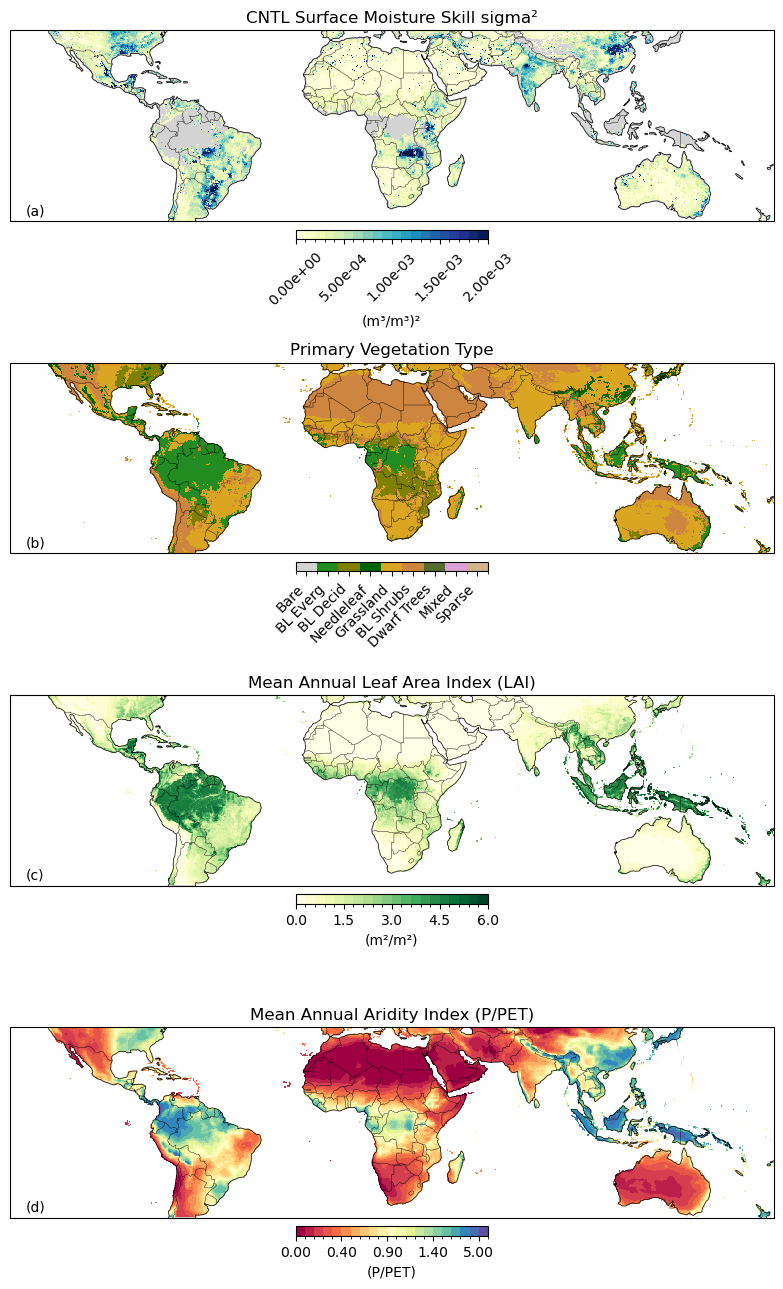

In [36]:
# ------------------------------
# 8) Figure S6 (4x1 maps)
# ------------------------------
vmin_sig2, vmax_sig2 = 0.0, 2e-3
edges_sig2 = np.linspace(vmin_sig2, vmax_sig2, 21)
cmap_sig2 = get_cmap('YlGnBu', len(edges_sig2) - 1)

lats_ease, lons_ease = load_ease_grid()
lats_row, lons_col = lats_ease[:, 1], lons_ease[1, :]
lon_grid, lat_grid = np.meshgrid(lons_col, lats_row)

# Helper to map lon/lat/value triplets to the EASE grid

def to_grid(values, lon_in, lat_in):
    arr = np.column_stack([values.flatten(), lon_in.flatten(), lat_in.flatten()])
    return build_ease_grid_mapping(arr, lats_row, lons_col)

# (a) CNTL sigma2 grid (uses TC lon/lat grid)
map_sig = np.empty([lons_tc_grid.size, 3])
map_sig.fill(np.nan)
map_sig[:, 0] = np.asarray(S0.get('sigma2_mod', np.nan)).flatten()
map_sig[:, 1] = lons_tc_grid.flatten()
map_sig[:, 2] = lats_tc_grid.flatten()

sig2_grid = build_ease_grid_mapping(map_sig, lats_row, lons_col)

# (b) Veg type grid (tile coord)
label_map = {0: 'Bare', 1: 'BL Everg', 2: 'BL Decid', 3: 'Needleleaf', 4: 'Grassland', 5: 'BL Shrubs', 6: 'Dwarf Trees', 7: 'Mixed', 8: 'Sparse'}
veg_colors = ['lightgray', 'forestgreen', 'olive', 'darkgreen', 'goldenrod', 'peru', 'darkolivegreen', 'plum', 'tan']
veg_cmap = ListedColormap(veg_colors[:len(label_map)])
veg_bounds = np.arange(-0.5, 9.5, 1.0)
veg_grid = to_grid(np.asarray(veg_type_out), np.where(com_lon > 180.0, com_lon - 360.0, com_lon), com_lat)

# (c) Mean LAI grid (aridity/LAI lon/lat)
lai_grid = to_grid(np.squeeze(mean_lai_clim), np.squeeze(lon_ai), np.squeeze(lat_ai))
edges_lai = np.linspace(0.0, 6.0, 21)
cmap_lai = get_cmap('YlGn', len(edges_lai) - 1)

# (d) Aridity grid
ai_grid = to_grid(np.squeeze(ai), np.squeeze(lon_ai), np.squeeze(lat_ai))
a_edges = np.array([0.00, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00, 1.10, 1.20, 1.30, 1.40, 1.50, 1.75, 2.00, 3.00, 5.00, 10.00])
cmap_ai = get_cmap('Spectral', len(a_edges) - 1)

fig, axes = plt.subplots(4, 1, figsize=(12, 13), subplot_kw={'projection': ccrs.PlateCarree()})

# (a) CNTL sigma2 map
ax0 = axes[0]
sc0 = ax0.pcolormesh(lon_grid, lat_grid, sig2_grid, cmap=cmap_sig2, norm=BoundaryNorm(edges_sig2, cmap_sig2.N), transform=ccrs.PlateCarree())
ax0.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax0.add_feature(cfeature.BORDERS, linewidth=0.3)
ax0.add_feature(cfeature.LAND, color='lightgray', zorder=0)
ax0.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
ax0.set_title('CNTL Surface Moisture Skill sigma²')
ax0.text(0.02, 0.02, '(a)', transform=ax0.transAxes, va='bottom', ha='left')
ax0.tick_params(labelbottom=False, labelleft=False)

cbar0 = fig.colorbar(sc0, ax=ax0, orientation='horizontal', pad=0.04, fraction=0.046)
cbar0.set_label('(m³/m³)²')
cbar0.set_ticks(edges_sig2[::5])
cbar0.ax.set_xticklabels([f"{t:.2e}" for t in edges_sig2[::5]], rotation=45)

# (b) Vegetation type
ax1 = axes[1]
sc1 = ax1.pcolormesh(lon_grid, lat_grid, veg_grid, cmap=veg_cmap, norm=BoundaryNorm(veg_bounds, veg_cmap.N), transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.BORDERS, linewidth=0.3)
ax1.add_feature(cfeature.LAND, color='lightgray', zorder=0)
ax1.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
ax1.set_title('Primary Vegetation Type')
ax1.text(0.02, 0.02, '(b)', transform=ax1.transAxes, va='bottom', ha='left')
ax1.tick_params(labelbottom=False, labelleft=False)

cbar1 = fig.colorbar(sc1, ax=ax1, orientation='horizontal', pad=0.04, fraction=0.046, boundaries=veg_bounds)
cbar1.set_ticks(list(label_map.keys()))
cbar1.set_ticklabels([label_map[k] for k in label_map])
for label in cbar1.ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

# (c) Mean LAI
ax2 = axes[2]
sc2 = ax2.pcolormesh(lon_grid, lat_grid, lai_grid, cmap=cmap_lai, norm=BoundaryNorm(edges_lai, cmap_lai.N), transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.add_feature(cfeature.BORDERS, linewidth=0.3)
ax2.add_feature(cfeature.LAND, color='lightgray', zorder=0)
ax2.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
ax2.set_title('Mean Annual Leaf Area Index (LAI)')
ax2.text(0.02, 0.02, '(c)', transform=ax2.transAxes, va='bottom', ha='left')
ax2.tick_params(labelbottom=False, labelleft=False)

cbar2 = fig.colorbar(sc2, ax=ax2, orientation='horizontal', pad=0.04, fraction=0.046)
cbar2.set_label('(m²/m²)')
cbar2.set_ticks(edges_lai[::5])
cbar2.ax.set_xticklabels([f"{t:.1f}" for t in edges_lai[::5]])

# (d) Aridity
ax3 = axes[3]
sc3 = ax3.pcolormesh(lon_grid, lat_grid, ai_grid, cmap=cmap_ai, norm=BoundaryNorm(a_edges, cmap_ai.N), transform=ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax3.add_feature(cfeature.BORDERS, linewidth=0.3)
ax3.add_feature(cfeature.LAND, color='lightgray', zorder=0)
ax3.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
ax3.set_title('Mean Annual Aridity Index (P/PET)')
ax3.text(0.02, 0.02, '(d)', transform=ax3.transAxes, va='bottom', ha='left')
ax3.tick_params(labelbottom=False, labelleft=False)

cbar3 = fig.colorbar(sc3, ax=ax3, orientation='horizontal', pad=0.04, fraction=0.046, boundaries=a_edges)
cbar3.set_label('(P/PET)')
positions = a_edges[::5]
cbar3.set_ticks(positions)
cbar3.ax.set_xticklabels([f"{t:.2f}" for t in positions])

plt.tight_layout()
save_fig(plt.gcf(), 'figure_S6')
plt.show()
